In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from pathlib import Path
from datetime import date
from tensorflow.keras.preprocessing import image

In [20]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [56]:
BASE_LOG_PATH = './logs/'
BATCH_SIZE = 10
LAST_TRAINABLE_LAYERS = 8
MODEL_TYPE = 'regression'
TIME = str(date.today()).replace(" ", "-")
# LOG_DIR = f"{BASE_LOG_PATH}{MODEL_TYPE}/test"
LOG_DIR = f"{BASE_LOG_PATH}{MODEL_TYPE}/{TIME}_batch_{BATCH_SIZE}_2p_layers_{LAST_TRAINABLE_LAYERS}"
print(f"Logging to {LOG_DIR}")
tensorboard_callback = TensorBoard(log_dir=LOG_DIR)

Logging to ./logs/regression/2021-02-04_batch_10_2p_layers_8


In [39]:
BASE_PATH = Path("../data/regression")
train = pd.read_csv( BASE_PATH / 'train_gt.csv')
train = train.drop(columns=['stdv'])
train["imagepath"] = BASE_PATH / 'train' / train['image']
train = train.astype({"imagepath" : 'string'})
train = train.astype({"image" : 'string'})
train = train.dropna()

val = pd.read_csv( BASE_PATH / 'valid_gt.csv')
val = val.drop(columns=["stdv"])
val["imagepath"] = BASE_PATH / 'valid' / val['image']
val = val.astype({"imagepath" : 'string'})
val = val.astype({"image" : 'string'})
val = val.dropna()


In [40]:
print(val)

           image       mean                            imagepath
0     005345.jpg  34.833333  ..\data\regression\valid\005345.jpg
1     005283.jpg  17.538462  ..\data\regression\valid\005283.jpg
2     004519.jpg  31.394737  ..\data\regression\valid\004519.jpg
3     004997.jpg  39.250000  ..\data\regression\valid\004997.jpg
4     004871.jpg  29.692308  ..\data\regression\valid\004871.jpg
...          ...        ...                                  ...
1495  005574.jpg  54.769231  ..\data\regression\valid\005574.jpg
1496  004727.jpg  25.696970  ..\data\regression\valid\004727.jpg
1497  004332.jpg  51.181818  ..\data\regression\valid\004332.jpg
1498  005373.jpg  40.480000  ..\data\regression\valid\005373.jpg
1499  005554.jpg  23.300000  ..\data\regression\valid\005554.jpg

[1500 rows x 3 columns]


In [41]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [42]:
train_gen = train_gen.flow_from_dataframe(dataframe=train, x_col="imagepath", y_col="mean", class_mode="raw",
                                          target_size=(224,224), batch_size=BATCH_SIZE)
valid_gen = valid_gen.flow_from_dataframe(dataframe=val, x_col="imagepath", y_col="mean", class_mode="raw",
                                          target_size=(224, 224), batch_size=BATCH_SIZE)

Found 4113 validated image filenames.
Found 1500 validated image filenames.


In [57]:
imgs, labels = next(train_gen)

In [58]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

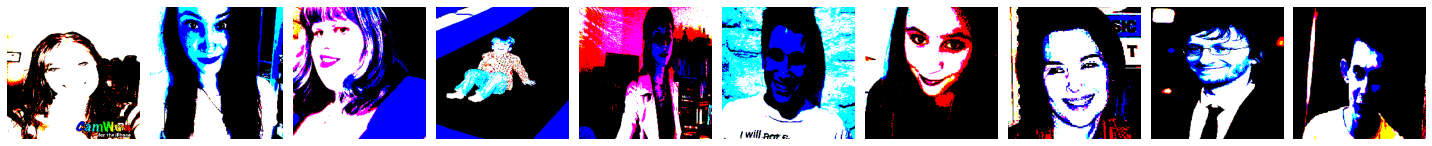

In [59]:
plotImages(imgs)

In [60]:
print(labels)

[20.         21.23076923 30.64285714  4.78947368 26.98113208 23.
 20.34482759 24.84615385 27.60526316 17.55172414]


In [47]:
vgg16_model = VGG16()

In [48]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [49]:
model = keras.Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [51]:
if not LAST_TRAINABLE_LAYERS:
    for layer in model.layers:
        layer.trainable = False
else:
    print(f"Setting trainable layers to {LAST_TRAINABLE_LAYERS}")
    for layer in vgg16_model.layers[:-LAST_TRAINABLE_LAYERS]:
        layer.trainable = False
        print(layer)

Setting trainable layers to 1


In [52]:
model.add(Dense(units=1))

In [63]:
#for layer in model.layers: 
 #   print(f"{layer}: {layer.trainable}")
#    layer.trainable = True 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [64]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="mean_absolute_error", metrics=[MeanAbsoluteError()])


In [65]:
model.fit(x=train_gen,steps_per_epoch=len(train_gen),validation_data=valid_gen, validation_steps=len(valid_gen), epochs=50, verbose=2, callbacks=[tensorboard_callback])

Epoch 1/50
412/412 - 39s - loss: 7.5417 - mean_absolute_error: 7.5441 - val_loss: 10.1432 - val_mean_absolute_error: 10.1432
Epoch 2/50
412/412 - 38s - loss: 7.0851 - mean_absolute_error: 7.0836 - val_loss: 8.0451 - val_mean_absolute_error: 8.0451
Epoch 3/50
412/412 - 38s - loss: 5.2310 - mean_absolute_error: 5.2284 - val_loss: 8.0718 - val_mean_absolute_error: 8.0718
Epoch 4/50
412/412 - 38s - loss: 4.5512 - mean_absolute_error: 4.5460 - val_loss: 7.6706 - val_mean_absolute_error: 7.6706
Epoch 5/50
412/412 - 38s - loss: 3.9324 - mean_absolute_error: 3.9348 - val_loss: 7.7722 - val_mean_absolute_error: 7.7722
Epoch 6/50
412/412 - 38s - loss: 3.5666 - mean_absolute_error: 3.5637 - val_loss: 7.5300 - val_mean_absolute_error: 7.5300
Epoch 7/50
412/412 - 39s - loss: 3.3488 - mean_absolute_error: 3.3450 - val_loss: 7.2937 - val_mean_absolute_error: 7.2937
Epoch 8/50
412/412 - 38s - loss: 3.1611 - mean_absolute_error: 3.1651 - val_loss: 7.4628 - val_mean_absolute_error: 7.4628
Epoch 9/50
412

In [ ]:
image_path = '../data/regression/train/Profile.jpg'
plt.imread(image_path)
plt.show()


In [ ]:
img = image.load_img(image_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)


prediction = model.predict(img_preprocessed)

print(prediction)